# Image Classification

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns

In [3]:
# Read Images
# img = mpimg.imread('Dataset/Train/egg ballado/4c2cd42040c108f95bb2484ee0b00590.jpg')

# Output Images
# plt.imshow(img)

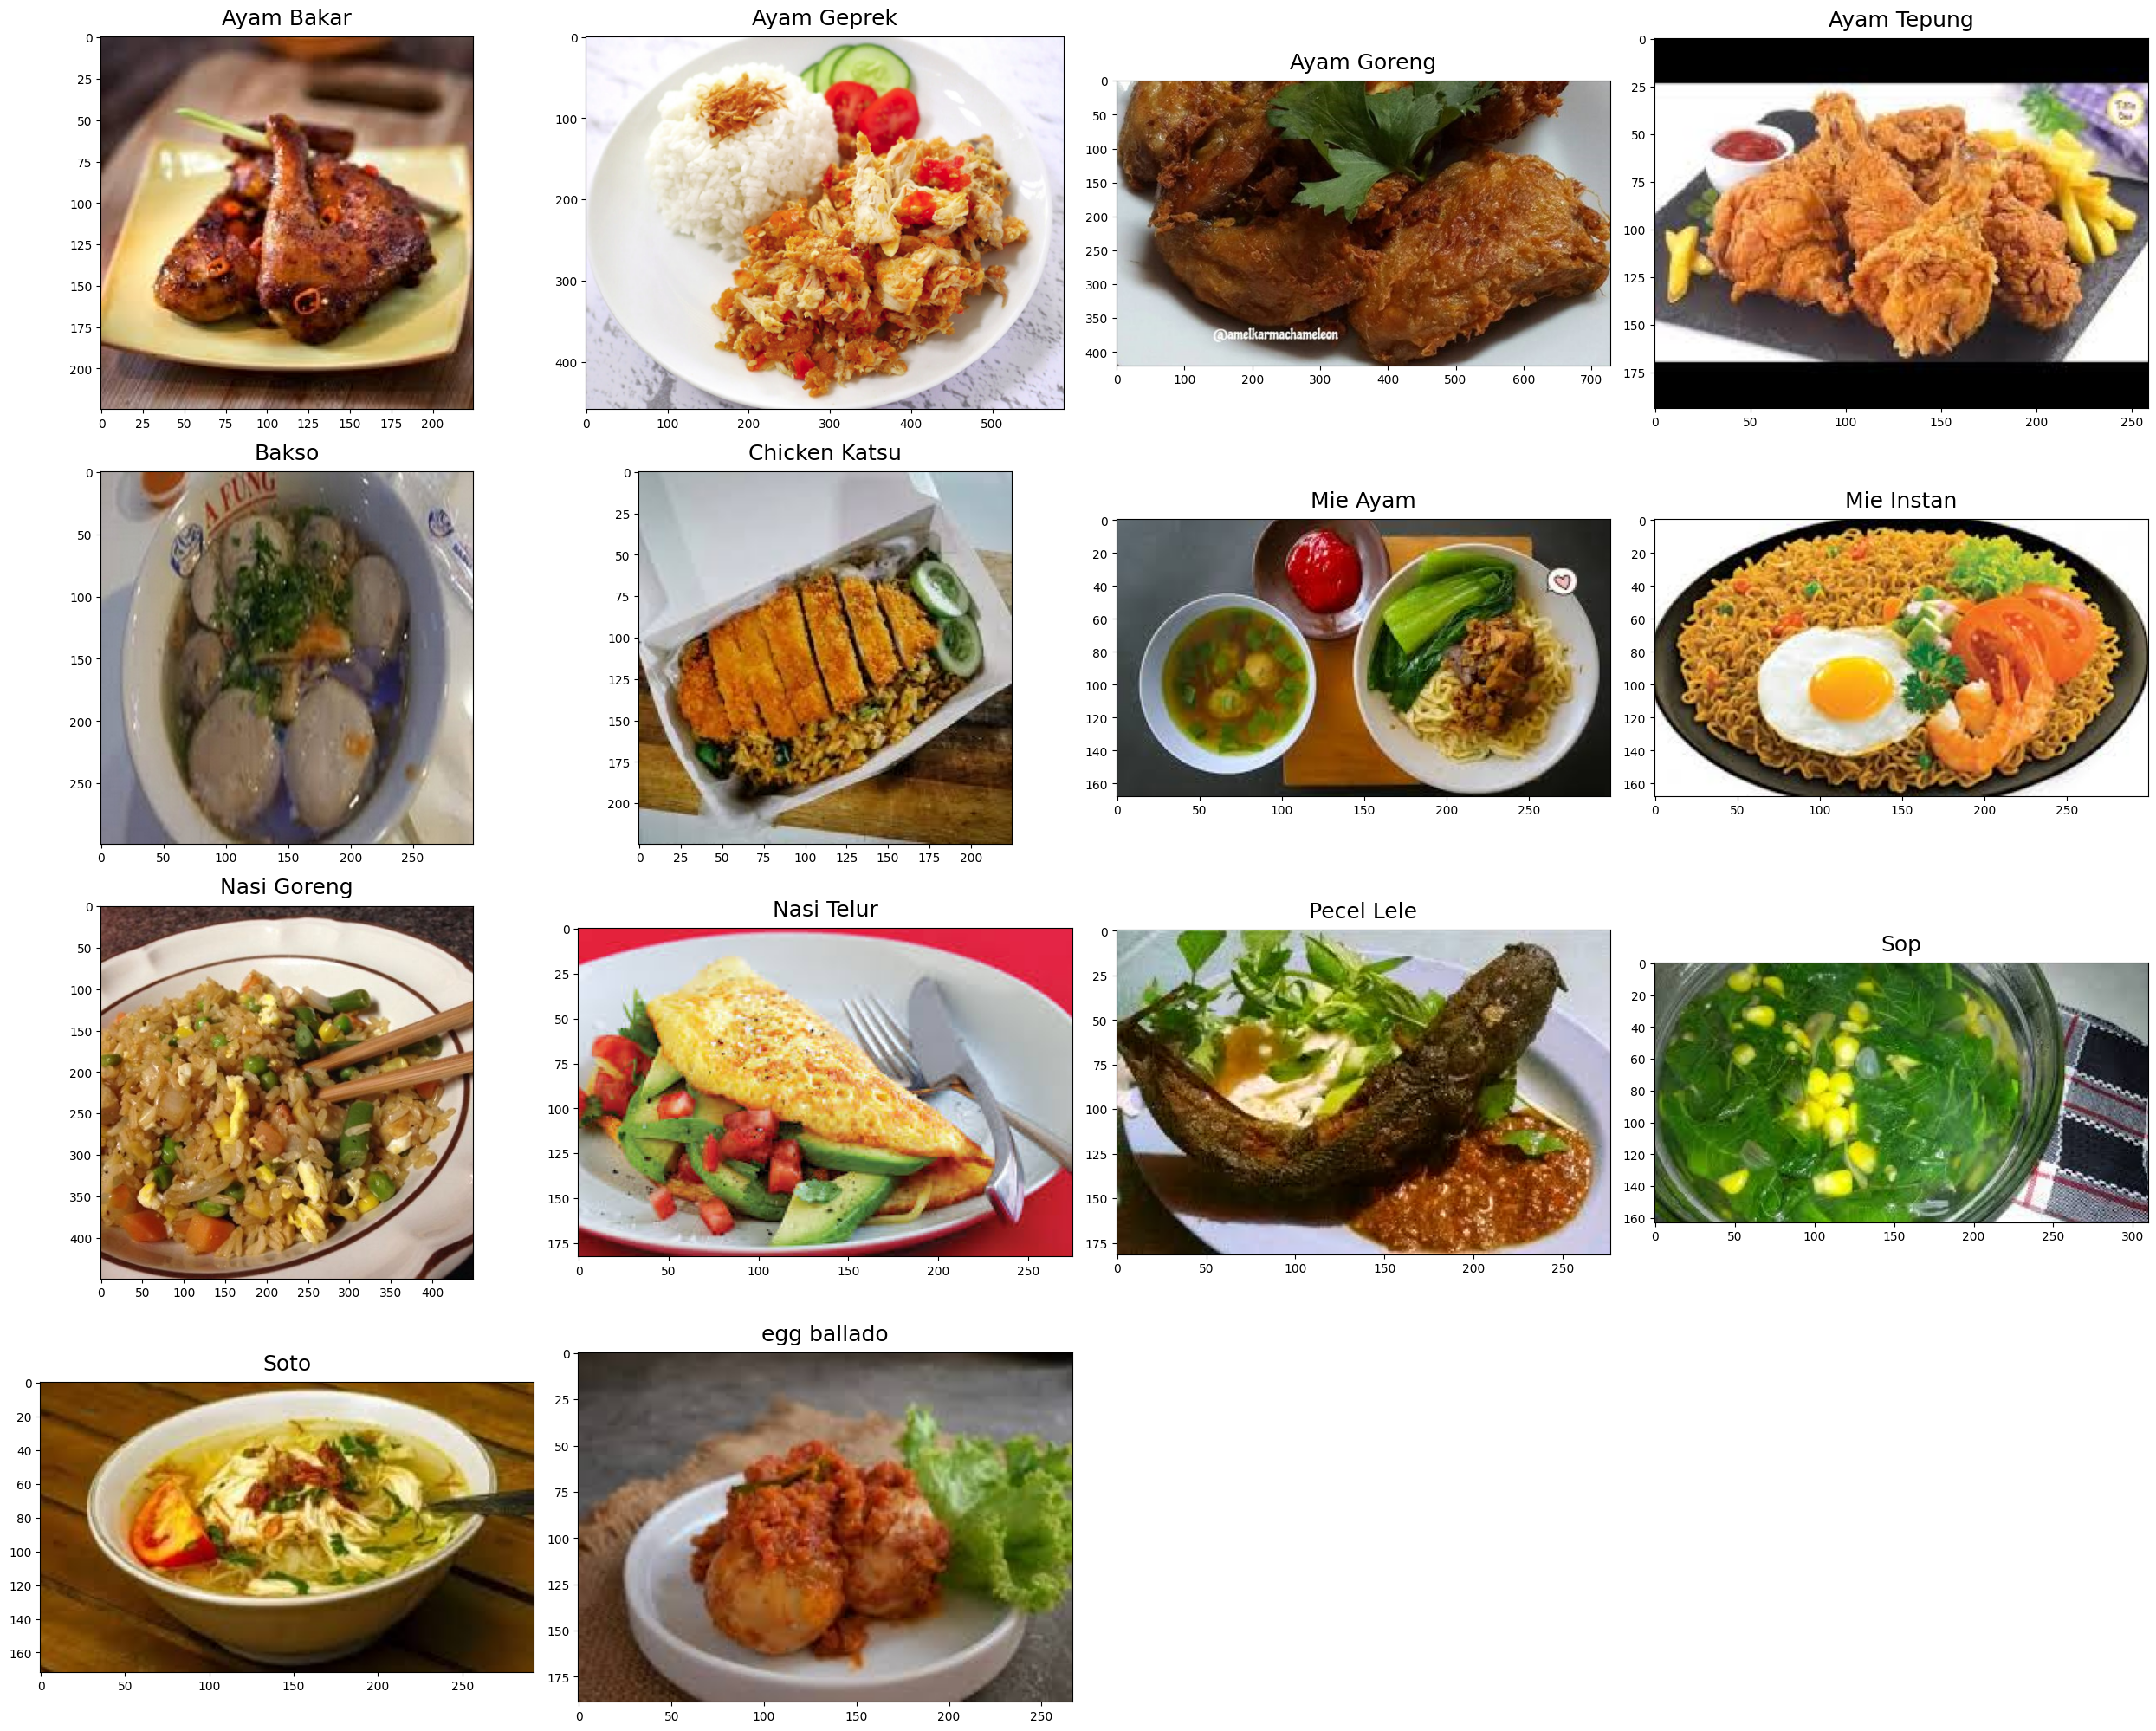

In [4]:
train_dir = "Image Eye\Train"
test_dir = "Image Eye\Test"
images = []

for food_folder in sorted(os.listdir(train_dir)):
    food_items = os.listdir(train_dir + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_dir,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)

plt.tight_layout()

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255,
                                                                rotation_range=50,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.5,
                                                                horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=62,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    batch_size=62,
                                                    class_mode='categorical')

Found 4699 images belonging to 14 classes.
Found 970 images belonging to 14 classes.


Pakai MobileNet ngga usah pakai link kaya Inception, langsung dipanggil aja tinggal ganti versionnya aja.

Referensi: https://github.com/EhabR98/Transfer-Learning-with-MobileNetV2/blob/main/Transfer_learning_with_MobileNet_v1-Copy1.md#3

Sumber coursera : https://colab.research.google.com/drive/1gfaEHcPhTgab4emO8FE8f-TxdZ4mTLV8?authuser=1 (Cuma pakai inception sih)

In [7]:
# # Convert generator to TensorFlow dataset
# train_dataset = tf.data.Dataset.from_generator(
#     lambda: train_generator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([None, 224, 224, 3], [None, 14])
# )

# # Repeat the dataset
# train_dataset = train_dataset.repeat()

In [15]:
import tensorflow as tf
# Loading the Pre-trained MobileNet Model
from tensorflow.keras.applications import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the Base Layer
for layer in base_model.layers[:-5]:
    layer.trainable = True

# last_layer = base_model.get_layer('conv_dw_8_relu')

# base_model.summary()

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='Model/model.weights.keras',
                                                                monitor='val_accuracy',
                                                                mode='max',
                                                                save_best_only=True)

Lanjut masukin model

In [17]:
model1 = tf.keras.models.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Dense(14, activation='softmax')  # Menggunakan softmax karena ini adalah klasifikasi multikelas
])

model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',  # Menggunakan categorical_crossentropy untuk klasifikasi multikelas
              metrics=['accuracy'])

In [18]:
# AKURASI AWALNYA 0.2 

history_mobileNet=model1.fit(train_generator,
                    validation_data=test_generator,
                    epochs=20, verbose=1)  # Sesuaikan jumlah langkah per epoch sesuai kebutuhan

Epoch 1/20
 1/76 ━━━━━━━━━━━━━━━━━━━━ 2:41:06 129s/step - accuracy: 0.0806 - loss: 3.2827

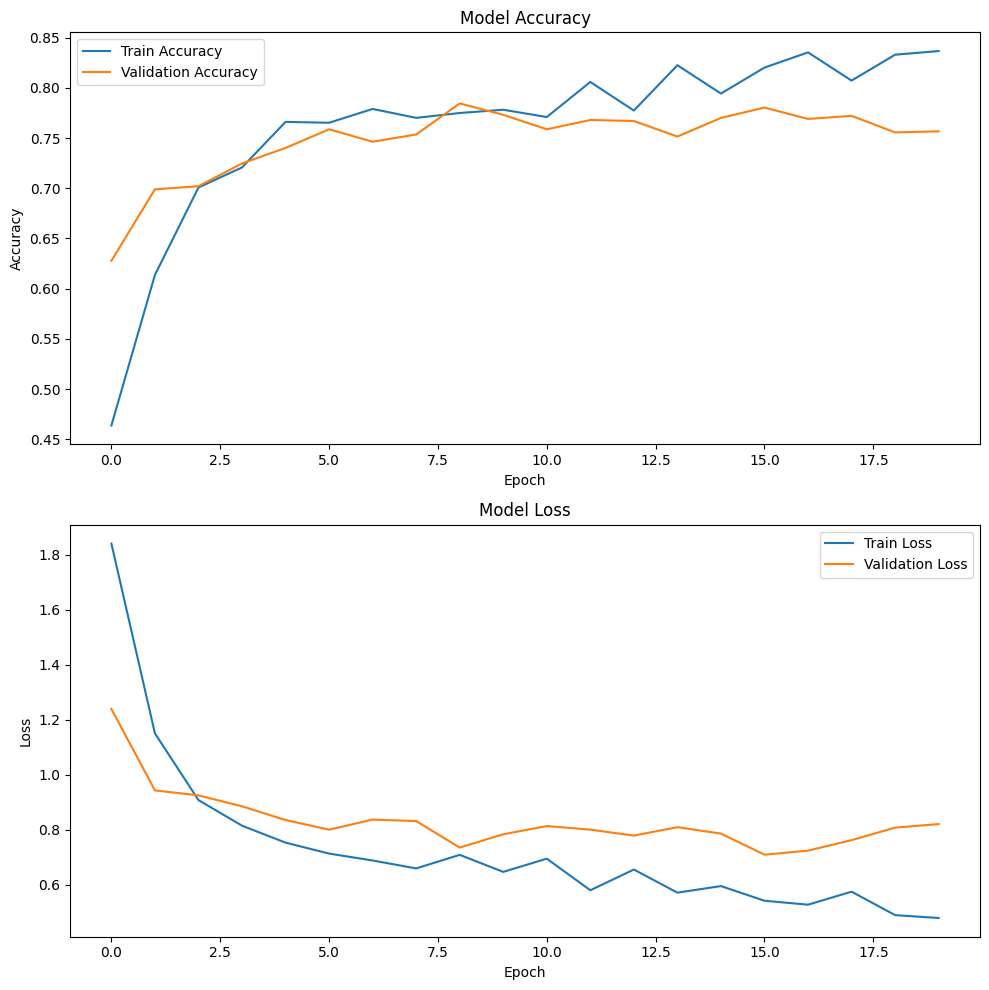

In [ ]:
def plot_accuracy_loss(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='best')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='best')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(history_mobileNet)


In [ ]:
from sklearn.metrics import f1_score, classification_report
import pandas as pd

# Membuat prediksi pada data uji
y_pred = model1.predict(test_generator)
y_true = test_generator.classes

# Menggunakan argmax untuk mendapatkan kelas prediksi
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung F1 score untuk setiap kelas
f1_scores = f1_score(y_true, y_pred_classes, average=None)

# Membuat laporan klasifikasi yang mencakup presisi, recall, dan F1 score untuk setiap kelas
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())

# Menampilkan F1 score untuk setiap kelas dalam tabel
f1_scores_table = pd.DataFrame({'Class': test_generator.class_indices.keys(), 'F1 Score': f1_scores})
print(f1_scores_table)

# Menampilkan laporan klasifikasi
print("Classification Report:\n", report)


16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
            Class  F1 Score
0      Ayam Bakar  0.074627
1     Ayam Geprek  0.019608
2     Ayam Goreng  0.000000
3     Ayam Tepung  0.102190
4           Bakso  0.107623
5   Chicken Katsu  0.115607
6        Mie Ayam  0.131737
7      Mie Instan  0.060000
8     Nasi Goreng  0.036364
9      Nasi Telur  0.000000
10     Pecel Lele  0.069930
11            Sop  0.027778
12           Soto  0.100559
13    egg ballado  0.066298
Classification Report:
                precision    recall  f1-score   support

   Ayam Bakar       0.06      0.11      0.07        45
  Ayam Geprek       0.02      0.02      0.02        48
  Ayam Goreng       0.00      0.00      0.00        87
  Ayam Tepung       0.10      0.11      0.10        66
        Bakso       0.10      0.11      0.11       105
Chicken Katsu       0.12      0.11      0.12        89
     Mie Ayam       0.11      0.16      0.13        70
   Mie Instan       0.10      0.04      0.06        70
  Nasi Goreng       0

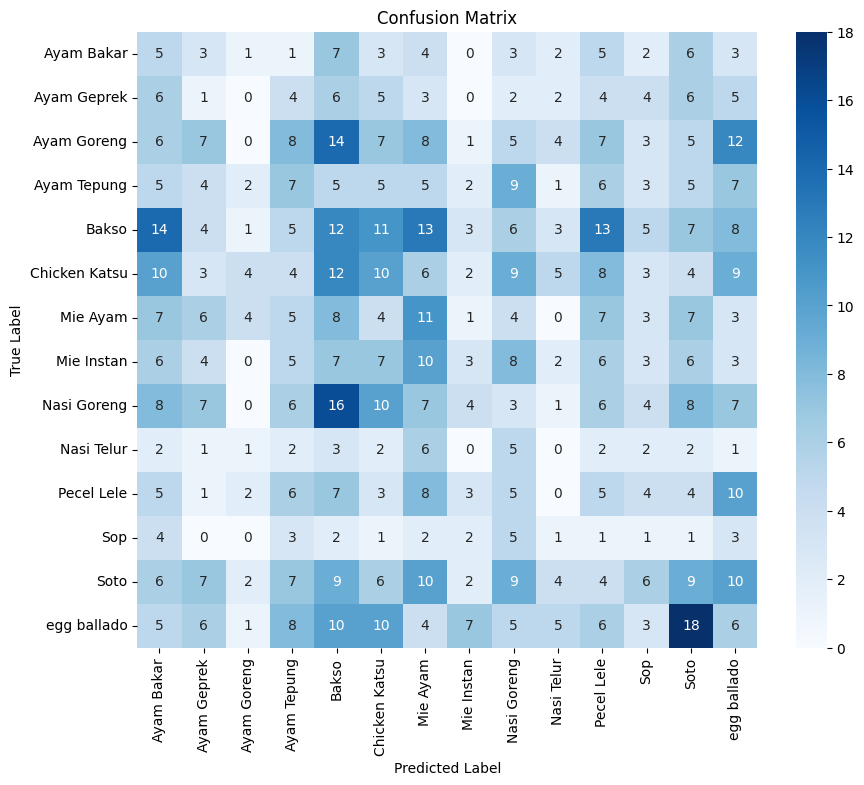

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Mendefinisikan nama kelas
class_names = test_generator.class_indices.keys()

# Membuat confusion matrix dalam bentuk DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Membuat visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Inception

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import urllib.request
import zipfile

inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [21]:
# train_generator = train_generator.repeat()

https://www.kaggle.com/code/mehrdadsadeghi/fashionmnist-cnn-with-tensorflow-confusionmatrix

In [22]:
model2 = tf.keras.models.Sequential([
  pre_trained_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Dense(14, activation='softmax')  # Menggunakan softmax karena ini adalah klasifikasi multikelas
])

model2.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='categorical_crossentropy',  # Menggunakan categorical_crossentropy untuk klasifikasi multikelas
              metrics=['accuracy'])

In [23]:
# AKURASI AWALNYA 0.2 

history_inceptionV3=model2.fit(train_generator,
                    validation_data=test_generator,
                    epochs=30, steps_per_epoch=20, verbose=1, validation_steps=5)  # Sesuaikan jumlah langkah per epoch sesuai kebutuhan

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.2352 - loss: 2.5097 - val_accuracy: 0.5100 - val_loss: 1.6536
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4784 - loss: 1.6727 - val_accuracy: 0.5000 - val_loss: 1.5344
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4379 - loss: 1.8084 - val_accuracy: 0.5000 - val_loss: 1.4674
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4560 - loss: 1.6598 - val_accuracy: 0.4700 - val_loss: 1.5800
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5207 - loss: 1.6853 - val_accuracy: 0.5400 - val_loss: 1.4056
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5242 - loss: 1.5102 - val_accuracy: 0.7000 - val_loss: 1.2933
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5446 - loss: 1.5416 - val_accuracy: 0.6600 - val_loss: 1.2021
Epoch 8/30
17/20 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5132 - loss: 1.5537

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5178 - loss: 1.5335 - val_accuracy: 0.6750 - val_loss: 0.9587
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5975 - loss: 1.2982 - val_accuracy: 0.5600 - val_loss: 1.4247
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5739 - loss: 1.4438 - val_accuracy: 0.7000 - val_loss: 1.2005
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5816 - loss: 1.4053 - val_accuracy: 0.5600 - val_loss: 1.3714
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5994 - loss: 1.3357 - val_accuracy: 0.6700 - val_loss: 1.2321
Epoch 13/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6632 - loss: 1.1241 - val_accuracy: 0.6100 - val_loss: 1.1218
Epoch 14/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5978 - loss: 1.3098 - val_accuracy: 0.6400 - val_loss: 1.1859
Epoch 15/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6341 - loss: 1.2081 - val_accuracy: 0.6600 - val_loss: 1.16

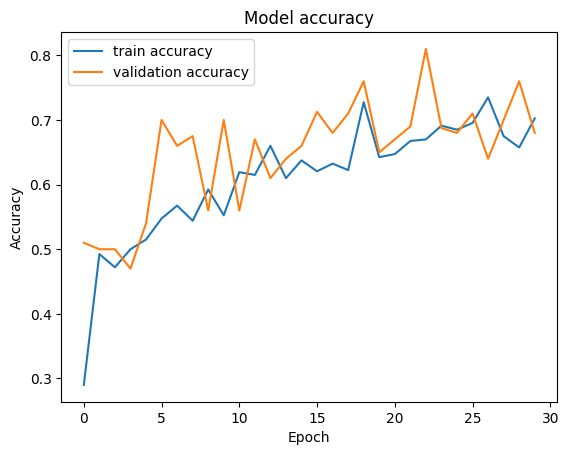

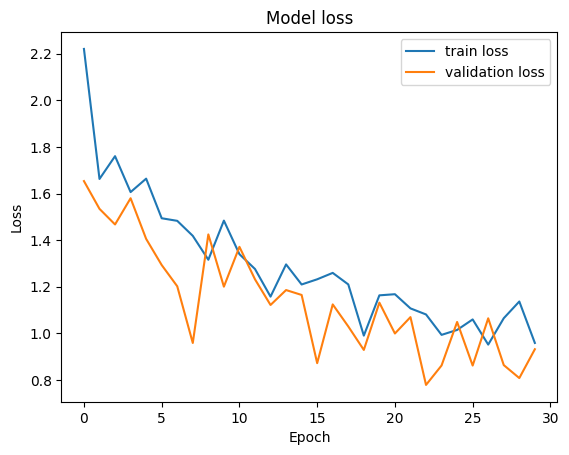

In [24]:
def plot_accuracy(history):
    plt.plot(history_inceptionV3.history['accuracy'],label='train accuracy')
    plt.plot(history_inceptionV3.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history_inceptionV3.history['loss'],label="train loss")
    plt.plot(history_inceptionV3.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

plot_accuracy(history_inceptionV3)
plot_loss(history_inceptionV3)

In [26]:
from sklearn.metrics import f1_score, classification_report
import pandas as pd

# Membuat prediksi pada data uji
y_pred = model2.predict(test_generator)
y_true = test_generator.classes

# Menggunakan argmax untuk mendapatkan kelas prediksi
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung F1 score untuk setiap kelas
f1_scores = f1_score(y_true, y_pred_classes, average=None)

# Membuat laporan klasifikasi yang mencakup presisi, recall, dan F1 score untuk setiap kelas
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())

# Menampilkan F1 score untuk setiap kelas dalam tabel
f1_scores_table = pd.DataFrame({'Class': test_generator.class_indices.keys(), 'F1 Score': f1_scores})
print(f1_scores_table)

# Menampilkan laporan klasifikasi
print("Classification Report:\n", report)


39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step
            Class  F1 Score
0      Ayam Bakar  0.038835
1     Ayam Geprek  0.059701
2     Ayam Goreng  0.067416
3     Ayam Tepung  0.065574
4           Bakso  0.131455
5   Chicken Katsu  0.096774
6        Mie Ayam  0.000000
7      Mie Instan  0.091954
8     Nasi Goreng  0.100000
9      Nasi Telur  0.000000
10     Pecel Lele  0.129630
11            Sop  0.041667
12           Soto  0.081301
13    egg ballado  0.000000
Classification Report:
                precision    recall  f1-score   support

   Ayam Bakar       0.06      0.03      0.04        72
  Ayam Geprek       0.07      0.05      0.06        40
  Ayam Goreng       0.08      0.06      0.07        50
  Ayam Tepung       0.08      0.06      0.07       107
        Bakso       0.10      0.19      0.13        74
Chicken Katsu       0.07      0.15      0.10        40
     Mie Ayam       0.00      0.00      0.00        49
   Mie Instan       0.11      0.08      0.09        50
  Nasi Goreng       0